# OVO Tutorial #2

# RENAME THIS FILE WITH YOUR LAST NAME

e.g., my name is Tony Silveti-Falls, so I would rename this file:

```
TP2_Silveti-Falls.ipynb
```

### Setup and Imports


In [274]:
# Libraries


import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.optimize import minimize

from typing import * #Just for clarytfing fonction types

# Configure matplotlib for notebook display
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Denoising with the ROF Model


## The ROF model

The ROF model for the forward model $x_d = x + \delta$ is given by
$$\min\limits_{u\in\mathbb{R}^{790\times790}}\frac{1}{2}\|u-x_d\|^2 + \lambda\|\nabla u\|_1$$
with $\nabla:\mathbb{R}^{790\times 790}\to(\mathbb{R}^{790\times 790})^2$

Load the noisy cat image `cat_noise.png` and store it as a numpy array.


In [275]:
# We load the grayscale image using imread and specifying that it's a grayscale image in the second argument
FILEPATH = "../data/"
gray = cv2.imread(FILEPATH + 'cat_noise.png', cv2.IMREAD_GRAYSCALE)

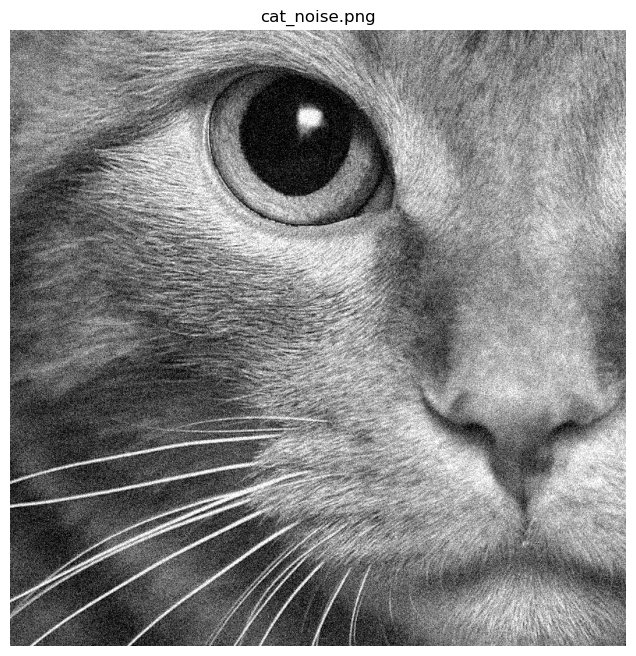

In [276]:
##Display loaded image

plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title("cat_noise.png")
plt.show()

## The Rockafellar-Fenchel duality theorem

The duality theorem tells us that for $f\in\Gamma_0(\mathbb{R}^{n\times n}, g\in\Gamma_0((\mathbb{R}^{n\times n})^2), K:\mathbb{R}^{n\times n}\to (\mathbb{R}^{n\times n})^2$ (and qualification conditions, see 15.24 in Bauschke and Combettes)

$$\min\limits_{u\in\mathbb{R}^{n\times n}} f(u) + g(Ku) \iff \min\limits_{z\in(\mathbb{R}^{n\times n})^2}f^*(K^*z) + g^*(-z)$$


### Applied to the ROF problem


In the ROF problem, $f \left( u \right) = \frac{1}{2} {\lVert u-x_d \rVert}^2$ et $g = \lambda \lVert \cdot \rVert_1$ with $K = \nabla$.

Moreover, $f^{*} (u) = sup_{x \in \mathbb{R}^n} <x, u> - f(x)$


#### Finding the conjugate of $f$


We can explicitly compute the convex conjugate of $f$.


In [277]:
def f_star(u:np.ndarray, x_d:np.ndarray) -> float:
    """Compute the convex conjugate of f

    Args:
        u (np.ndarray): vector
        x_d (np.ndarray): vector (gray noised image here)

    Returns:
        float: computed value for the convex conjugate of f
    """
    return .5 * np.sum(u**2) + np.dot(u, x_d)

#### Finding the conjugate of $g$


Here, since $g = \lambda \lVert \cdot \rVert_1$, we have a determinate form of its conjugate (Example 27 of Lecture 3)


In [278]:
def g_star(x:np.ndarray, lambda_:float) -> Literal[1] | Literal[0]:
    """Compute the conjugate of g for a vector x

    Args:
        x (np.ndarray): vector
        lambda_ (float): lambda parameter

    Returns:
        Literal[1] | Literal[0]: return the conjugate of g applied to vector x
    """
    return np.inf if np.linalg.norm(x, ord=np.inf) >= lambda_ else 0

#### Finding the adjoint of $\nabla$

Recall that in general an adjoint is the unique linear associated to a linear operator $A:\mathcal{X}\to\mathcal{Y}$ between Hilbert spaces $\mathcal{X}$ and $\mathcal{Y}$ such that
$$\langle Ax, y\rangle = \langle x, A^*y\rangle$$
for all $x\in\mathcal{X}$ and all $y\in\mathcal{Y}$. So, the trick to calculating the adjoint is to write down the inner product between $Ax$ and $y$ and try to rewrite this as an inner product of "something" with just $x$. Whatever the "something" we get is, that is the adjoint.

Note: for this problem we will assume that $\nabla$ is discretized according to the forward finite difference scheme with periodic boundary conditions (meaning we assume that $x_{1,j}$ and $x_{790,j}$ are neighbors for all $1\leq j\leq 790$ and similarly for the rows.


The conjugate of the gradient operator is the negative divergence operator, which we can compute explicitly.


In [279]:
def gradient(image:np.ndarray) -> np.ndarray:
    """Compute the gradient operator by forward finite difference

    Args:
        image (np.ndarray): numpy bidimensional vector

    Returns:
        np.ndarray: Gradient applied to this vector
    """
    grad_x = np.roll(image, -1, axis=1) - image
    grad_y = np.roll(image, -1, axis=0) - image
    return np.stack((grad_x, grad_y), axis=-1)

def divergence(p:np.ndarray) -> np.ndarray:
    """Explicitly compute the divergence operator applid to a vector

    Args:
        p (np.ndarray): vector of shape (790, 790, 2)

    Returns:
        np.ndarray: Negative divergence operator applied to vector p
    """
    div_x = p[..., 0] - np.roll(p[..., 0], 1, axis=1)  # Backward difference in x
    div_y = p[..., 1] - np.roll(p[..., 1], 1, axis=0)  # Backward difference in y
    return div_x + div_y

Check that the adjoint is computed correctly:


In [280]:
# Verify adjoint relationship
u = np.random.rand(790, 790)
p = np.random.rand(790, 790, 2)

grad_u = gradient(u)
div_p = - divergence(p)

print(f"Both left and right values are close : {np.isclose(np.sum(grad_u * p), np.sum(u * div_p))}") # Should use np.isclose instead of == beacause of small differences due to computation issues

Both left and right values are close : True


## Applying Forward-Backward splitting

You may assume that the operator norm of $\nabla^*\nabla$ is bounded in this setting (periodic boundary conditions, neighbors only vertical/horizontal) by $8$.

#### Implementing the Forward-Backward algorithm

Note: the formula to recover the primal solution from the dual solution should be $x_d + \nabla^*y^\star$ where $y^\star$ is a dual solution.


In [281]:
def gradient_f(u:np.ndarray, x_d:np.ndarray) -> np.ndarray:
    """Compute the gradient of f(u) = 1/2 ||u - x_d||^2

    Args:
        u (np.ndarray): image vector
        x_d (np.ndarray): noised image vector

    Returns:
        np.ndarray: computed gradient of f
    """
    return u - x_d

def prox_operator(u:np.ndarray, tau_lambda:float) -> np.ndarray:
    """Proximity operator for g

    Args:
        u (np.ndarray): vector
        tau_lambda (float): parameter

    Returns:
        np.ndarray: proximity operator applied to vector u
    """
    return np.sign(u) * np.maximum(0, np.abs(u) - tau_lambda)

def primal_functional(u:np.ndarray, x_d:np.ndarray, lambda_:float) -> float:
    """Primal functional F(u) = 1/2 ||u - x_d||^2 + lambda ||u||_1

    Args:
        u (np.ndarray): vector
        x_d (np.ndarray): vector (noised image)
        lambda_ (float): lambda parameter

    Returns:
        float: Computed primal functional
    """
    return 0.5 * np.linalg.norm(u - x_d)**2 + lambda_ * np.linalg.norm(u, ord=1)

def dual_functional(y:np.ndarray, x_d:np.ndarray, lambda_:float) -> float:
    """Dual functional G(y) = f^*(y) + g^*(y).

    Args:
        y (np.ndarray): vector
        x_d (np.ndarray): vector (noised image)
        lambda_ (float): lambda parameter

    Returns:
        float: Computed primal functional
    """
    return f_star(y, x_d) + g_star(y, lambda_)

def forward_backward(u:np.ndarray, x_d:np.ndarray, tau:float, lambda_:float, num_iterations:int=100) -> np.ndarray:
    """Forward Backward Algorithm

    Args:
        u (np.ndarray): Initial estimation of noised image
        x_d (np.ndarray): Noise dimage to approximate
        tau (float): Step size of the Forward-Backward Algorithm
        lambda_ (float): _description_
        num_iterations (int, optional): _description_. Defaults to 100.

    Returns:
        np.ndarray: _description_
    """
    
    # Initialize dual variable y
    y = np.zeros_like(u)  # Dual variable y_star

    # List to store the differences between primal and dual functionals
    functional_differences = []

    for _ in range(num_iterations):
        # Forward step: gradient descent on f(u)
        grad_f_u = gradient_f(u, x_d)
        y_half = y + tau * grad_f_u  # Update dual variable
        u_half = u - tau * grad_f_u
        
        # Backward step: proximity operator for g(u)
        u_next = prox_operator(u_half, tau * lambda_)
        
        # Update u
        u = u_next
        y = y_half

        # Compute primal and dual functionals
        primal_value = primal_functional(u, x_d, lambda_)
        dual_value = dual_functional(y, x_d, lambda_)
        
        # Compute the difference and store it
        functional_differences.append(primal_value - dual_value)
    
    return u, functional_differences

#### Testing the algorithm

Run the algorithm and plot the objective function values. Plot the image you recover.


In [282]:
# Denoise using ROF
lambda_ = .5
gamma = .1
u_init = np.zeros_like(gray)
denoised_image, functional_differences = forward_backward(u_init, gray, gamma, lambda_)

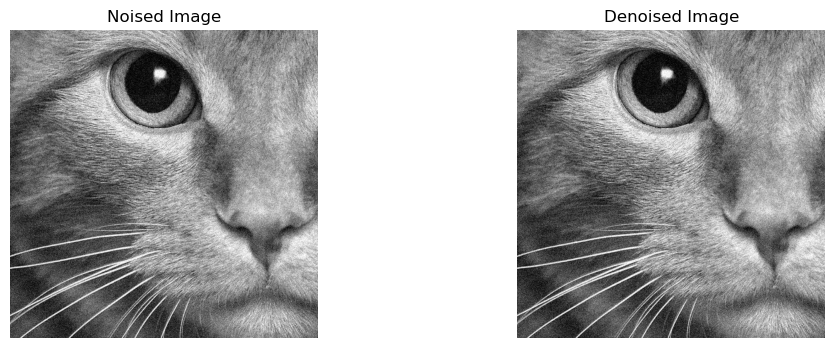

In [283]:
# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Noised Image")
plt.axis("off")
plt.imshow(gray, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Denoised Image")
plt.axis("off")
plt.imshow(denoised_image, cmap="gray")

plt.show()

We can compare the primal and minus the dual functional values; the duality theorem says they should be equal. Plot their difference here.


In [284]:
# Plot the difference between primal and dual functionals
## There is an error in my dual functional, and therefore I cannot displayed it, hence why this part of the code is commented

#plt.plot(functional_differences)
#plt.xlabel('Iteration')
#plt.ylabel('Primal - Dual Functional Difference')
#plt.title('Difference Between Primal and Dual Functionals')
#plt.grid(True)
#plt.show()

## Applying FISTA


Using the same formulation that you used for forward-backward splitting, apply FISTA.

#### Implementing FISTA


#### Testing the algorithm

Run the algorithm and plot the objective values. Plot the image you recover.


# Frank-Wolfe for inpainting


We consider the problem of recovering an image given only a partial observation. This is also known as inpainting. We will model our prior on the distribution of natural images as those images whose nuclear norm is sufficiently small, i.e.,
$$\min\limits_{x\in\mathcal{B}} \frac{1}{2}\|Ax-b\|_2^2$$
where $\mathcal{B}$ is the nuclear norm ball of radius $\rho>0$, $A$ is the linear operator (mask) that maps $x$ to its partial observations, and $b$ is partial observation of the ground truth, possibly corrupted by AWGN.

Write a function that generates a random mask, that can be used to model $A$, as a function of the percentage of entries observed.


In [285]:
def random_mask(p:float, size:tuple) -> np.ndarray:
    """Generate a random mask of given size

    Args:
        p (float): Proportion of observed entries
        size (tuple): Size of mask

    Returns:
        np.ndarray: mask
    """
    return np.random.binomial(1, p, size=size)

Write a function that computes the linear minimization oracle associated to $\mathcal{B}$ as a function of $\rho$ the radius of the ball.


In [295]:
def gradient(A:np.ndarray, x:np.ndarray, b:np.ndarray) -> np.ndarray:
    """Compute the gradient of the objective function
    Args:
        A (np.ndarray): Inpainting mask
        x (np.ndarray): Candidate for reconstructed image
        b (np.ndarray): Original image (as an numpy array)

    Returns:
        np.ndarray: Gradient of the objective function
    """
    b_flat = b.flatten()
    return A.T @ (A @ x - b_flat)

def linear_minimization_oracle(A:np.ndarray, x:np.ndarray, b:np.ndarray, rho:float) -> np.ndarray:
    """Compute the linear minimization oracle

    Args:
        A (np.ndarray): Inpainting mask
        x (np.ndarray): Candidate for reconstructed image
        b (np.ndarray): Original image (as an numpy array)
        rho (float): Radius of the ball

    Returns:
        np.ndarray: Linear minimization oracle
    """
    grad = gradient(A, x, b)
    grad_norm = np.linalg.norm(grad)

    # Project the gradient onto the ball
    if grad_norm > rho:
        d = (grad / grad_norm) * rho
    else:
        d = grad

    return d

Write a function to compute the objective $f(x)$.


In [287]:
def objective_function(A:np.ndarray, x:np.ndarray, b:np.ndarray) -> float:
    """Compute the objective function for A, x and b

    Args:
        A (np.ndarray): Binary mask
        x (np.ndarray): Candidate for reconstructed image
        b (np.ndarray): Original image (as an numpy array)

    Returns:
        float: _description_
    """
    b_flat = b.flatten()
    return .5 * np.linalg.norm(A @ x - b_flat)

Write the Frank-Wolfe algorithm and apply it using a mask that you generate applied to the image house_noise
.jpg with $\rho = 1000$ for 500 iterations.


In [288]:
def frank_wolfe(A:np.ndarray, b:np.ndarray, x_init:np.ndarray, rho:np.ndarray, max_iter:int=500) -> tuple[np.ndarray, list, list]:
    """Compute the Frank-Wolfe Algorithm

    Args:
        A (np.ndarray): Inpainting mask
        b (np.ndarray): Original Image
        x_init (np.ndarray): Initial candidate. Should have the same shape as b
        rho (np.ndarray): Ball radius
        max_iter (int, optional): Number of maximum iterations. Defaults to 100.

    Returns:
        tuple[np.ndarray, list, list]: Tuple consisting of the solution Image, obejctive values list and frank-wolfe gap values list
    """
    objective_values = []
    frank_wolfe_gap = []
    x = x_init.copy()

    for k in range(max_iter):
        # Compute the gradient at the current point
        grad = gradient(A, b, x)
        
        # Solve the linear minimization oracle to get the direction d
        s = linear_minimization_oracle(A, b, x, rho)
        
        # Compute the step size
        gamma = 2 / (k + 2)  # Standard step size in Frank-Wolfe
        
        # Update the solution
        x = x - gamma * (x - s)

        # Record the objective function value and frank wolfe gap
        objective_values.append(objective_function(A, b, x))
        frank_wolfe_gap.append(np.dot(grad, x-s))

    return x, objective_values, frank_wolfe_gap

In [294]:
# Parameters
p = .3
rho = 1000

# We load the grayscale image using imread and specifying that it's a grayscale image in the second argument
FILEPATH = "../data/"
gray = cv2.imread(FILEPATH + 'house_noise.jpg', cv2.IMREAD_GRAYSCALE)

# Generate Inpainting mask
A = random_mask(p, gray.shape)

# Compute the Frank-Wolfe Algorithm

image, objective_values, frank_wolfe_gap = frank_wolfe(A, gray, np.zeros_like(gray), rho)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Noised Image")
plt.axis("off")
plt.imshow(gray, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Denoised Image")
plt.axis("off")
plt.imshow(image.reshape(gray.shape), cmap="gray")

plt.show()

# There is a shape problem while computing the gradient of the objective function, and I can't see why. If you fix it, the following cells should work as well

(763, 1077) (763, 1077)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 763 is different from 1077)

Plot the objective function values as well as the so-called Frank-Wolfe gap $\langle \nabla f(x_k), x_k-s_k\rangle$ which is a certificate of optimality.


In [ ]:
plt.plot(objective_values)
plt.xlabel('Iteration')
plt.ylabel('Objective Values')
plt.title('Plot of the objective values during optimization')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(frank_wolfe_gap)
plt.xlabel('Iteration')
plt.ylabel('Frank-Wolfe Gap')
plt.title('Plot of the Frank-Wolfe Gap during optimization')
plt.grid(True)
plt.show()

Apply FISTA to solve this problem and compare the results with the results of Frank-Wolfe in terms of objective values. Start by writing the $\mathrm{prox}$ for the nonsmooth function in this problem.


# SUBMISSION

To submit your file, send an email to:

```
antonio.silveti-falls@centralesupelec.fr
```

with the subject line:

```
TP2_YOURNAME
```

where YOURNAME is your last name, just like in the file name.

**IF YOU DO NOT DO THIS, YOU WILL NOT GET CREDIT FOR YOUR WORK.**
